Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

Submission File
For each id in the test set, you must predict a probability for the target variable. The file should contain a header and have the following format:

https://www.kaggle.com/c/tabular-playground-series-nov-2021/overview

In [33]:
!conda info


     active environment : kaggle-pgdec21
    active env location : C:\ProgramData\Anaconda3\envs\kaggle-pgdec21
            shell level : 1
       user config file : C:\Users\globetrekker\.condarc
 populated config files : C:\Users\globetrekker\.condarc
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __win=0=0
                          __archspec=1=x86_64
       base environment : C:\ProgramData\Anaconda3  (writable)
      conda av data dir : C:\ProgramData\Anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2

In [34]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [110]:
import time, gc, copy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [62]:
import optuna
import utility

pd.options.mode.chained_assignment = None  # default='warn'
%config Completer.use_jedi = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [104]:
def get_scaled_df(X_in, X_test_in, scale_features):
    df_scale = X_in[scale_features]
    df_test_scale = X_test_in[scale_features]

    ct = ColumnTransformer([('scale', StandardScaler(), scale_features)], remainder='passthrough')

    df_scale = pd.DataFrame(ct.fit_transform(df_scale))
    df_test_scale = pd.DataFrame(ct.transform(df_test_scale))

    X_in[scale_features] = df_scale
    X_test_in[scale_features] = df_test_scale

    for col in scale_features:
        X_in[col] = df_train[col].astype('float32')
        X_test_in[col] = df_test[col].astype('float32')
        
    return X_in, X_test_in

In [163]:
def get_datasets(path):
    df_train = pd.read_csv(path + 'train.csv')
    df_test = pd.read_csv(path + 'test.csv')

    # drop this because only 1 row
    df_train.drop(list(df_train[df_train['Cover_Type']==5].index), axis=0, inplace=True)

    # drop these because only 1 value
    for col in df_train.columns:
        if df_train[col].nunique() == 1:
            print(col)
            df_train.drop(col, axis=1, inplace=True)
            df_test.drop(col, axis=1, inplace=True)

    # drop these because no additional info
    ids = df_test['Id']
    df_train.drop(['Id'], axis=1, inplace=True)
    df_test.drop(['Id'], axis=1, inplace=True)
    
    memory_usage = df_train.memory_usage(deep=True) / 1024 ** 2
    print('start mem %.2f MB' % (memory_usage.sum()))

    for col in df_train.columns:
        if 'Soil_Type' in col:
            df_train[col] = df_train[col].astype('category')
            df_test[col] = df_test[col].astype('category')
            continue
        if 'Wilderness' in col:
            df_train[col] = df_train[col].astype('category')
            df_test[col] = df_test[col].astype('category')
            continue
        if 'Cover_Type' in col:
            df_train[col] = df_train[col].astype('uint8')
            continue

        if df_train[col].min() >= 0 and df_train[col].max() <= 255:
            df_train[col] = df_train[col].astype('uint8')
            df_test[col] = df_test[col].astype('uint8')
        elif df_train[col].min() >= 0 and df_train[col].max() <= 65535:
            df_train[col] = df_train[col].astype('uint16')
            df_test[col] = df_test[col].astype('uint16')
        elif df_train[col].min() >= -128 and df_train[col].max() <= 127:
            df_train[col] = df_train[col].astype('int8')
            df_test[col] = df_test[col].astype('int8')
        elif df_train[col].min() >= -32768 and df_train[col].max() <= 32767:
            df_train[col] = df_train[col].astype('int16')
            df_test[col] = df_test[col].astype('int16')

    memory_usage = df_train.memory_usage(deep=True) / 1024 ** 2
    print('end mem %.2f MB' % (memory_usage.sum()))
    
    return df_train, df_test, ids

In [107]:
def split_dataset(df_train, df_test, target):
    original_features = df_test.columns
    X = df_train[original_features]
    y = df_train[target]
    X_train, X_val, y_train, y_val = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        train_size=0.8, 
        stratify=y)
    
    return X_train, X_val, y_train, y_val, original_features

In [136]:
def get_baseline_score(model_in, X_in, X_val_in, y_in, y_val_in):
    
    model_in.fit(X_in, y_in)
    preds = model_in.predict(X_val_in)
    val_score = accuracy_score(y_val_in, preds)
    print('val score %.3f' % (val_score))

    scores = cross_val_score(
            model_in,
            X_in,
            y_in,
            scoring='accuracy',
            cv=5,
            n_jobs=-1,
            )
    
    cv_score = scores.mean()
    print('cross val score %.3f' % (cv_score))
    
    return val_score, cv_score

val score 0.955
0.9506652984159937


In [164]:
def get_drop_scores(model_in, X_in, X_val_in, y_in, y_val_in, init):
    """get scores by dropping columns"""

    if init:
        drop_scores = []
        for col in X_in.columns:
            print(col)
            X_train_new = copy.deepcopy(X_in)
            X_val_new = copy.deepcopy(X_val_in)
            model_new = copy.deepcopy(model_in)
            X_train_new.drop([col], axis=1, inplace=True)
            X_val_new.drop([col], axis=1, inplace=True)

            model_new.fit(X_train_new, y_in)
            preds = model_new.predict(X_val_new)
            val_score = accuracy_score(y_val_in, preds)

            scores = cross_val_score(
                    model_new,
                    X_train_new,
                    y_in,
                    scoring='accuracy',
                    cv=5,
                    n_jobs=-1,
                    )
            cv_score = scores.mean()

            new_row = {'col': col, 'val_score': val_score, 'cv_score': cv_score}
            drop_scores.append(new_row)
        df = pd.DataFrame(drop_scores)
        df.to_csv('drops.csv')
            
    df_drops = pd.read_csv('drops.csv')
    cols = ['col', 'val_score', 'cv_score']
    df_drops = df_drops[cols]

    return df_drops

In [160]:
# max_val_score = list(df_drops.sort_values(by='val_score', ascending=False).head(15).loc[:, 'col'])
# max_cv_score = list(df_drops.sort_values(by='cv_score', ascending=False).head(15).loc[:, 'col'])
# for col in max_cv_score:
#     if col in max_val_score:
#         print(col)

# print(max_val_score)
# print(max_cv_score)

Soil_Type5
Soil_Type18
['Soil_Type18', 'Soil_Type21', 'Aspect', 'Soil_Type5', 'Soil_Type14', 'Slope', 'Soil_Type28', 'Soil_Type27', 'Hillshade_3pm', 'Wilderness_Area1', 'Wilderness_Area4', 'Soil_Type23', 'Hillshade_Noon', 'Soil_Type11', 'Soil_Type26']
['Hillshade_9am', 'Soil_Type4', 'Soil_Type13', 'Soil_Type5', 'Soil_Type34', 'Soil_Type32', 'Soil_Type6', 'Soil_Type22', 'Soil_Type3', 'Soil_Type16', 'Soil_Type1', 'Soil_Type9', 'Soil_Type18', 'Soil_Type29', 'Soil_Type20']


In [91]:
# model = LGBMClassifier(random_state=5)
# X_new = copy.deepcopy(X)
# X_new['Diagonal_Distance_To_Hydrology'] = (X_new['Horizontal_Distance_To_Hydrology'] ** 2 \
#                                             + X_new['Vertical_Distance_To_Hydrology']) ** 0.5
# scores = cross_val_score(
#         model,
#         X_new,
#         y,
#         scoring='accuracy',
#         cv=5,
#         n_jobs=-1,
#         )
# print(scores.mean())

0.9485194864818581


In [69]:
# model.fit(X, y)

LGBMClassifier(random_state=5)

In [71]:
# preds = model.predict(df_test)

# output = pd.DataFrame({'Id': ids, 'Cover_Type': preds})
# output.to_csv('submission.csv', index=False)

In [131]:
df_temp = copy.deepcopy(df_train)
for col in df_temp.columns:
    if df_temp[col].dtypes == 'category':
        df_temp[col] = df_temp[col].astype('uint8')

target = df_temp['Cover_Type']
features = df_temp.drop('Cover_Type', axis=1)
df_temp_a = features.iloc[:, :27]
df_temp_b = features.iloc[:, 27:]

df_temp_a = pd.concat([df_temp_a, target], axis=1)
df_temp_b = pd.concat([df_temp_b, target], axis=1)

In [130]:
df_temp_a.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Cover_Type
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,1
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,2
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,1
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,2
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
corrmat = df_temp_a.corr()
top_corr_features = corrmat.index

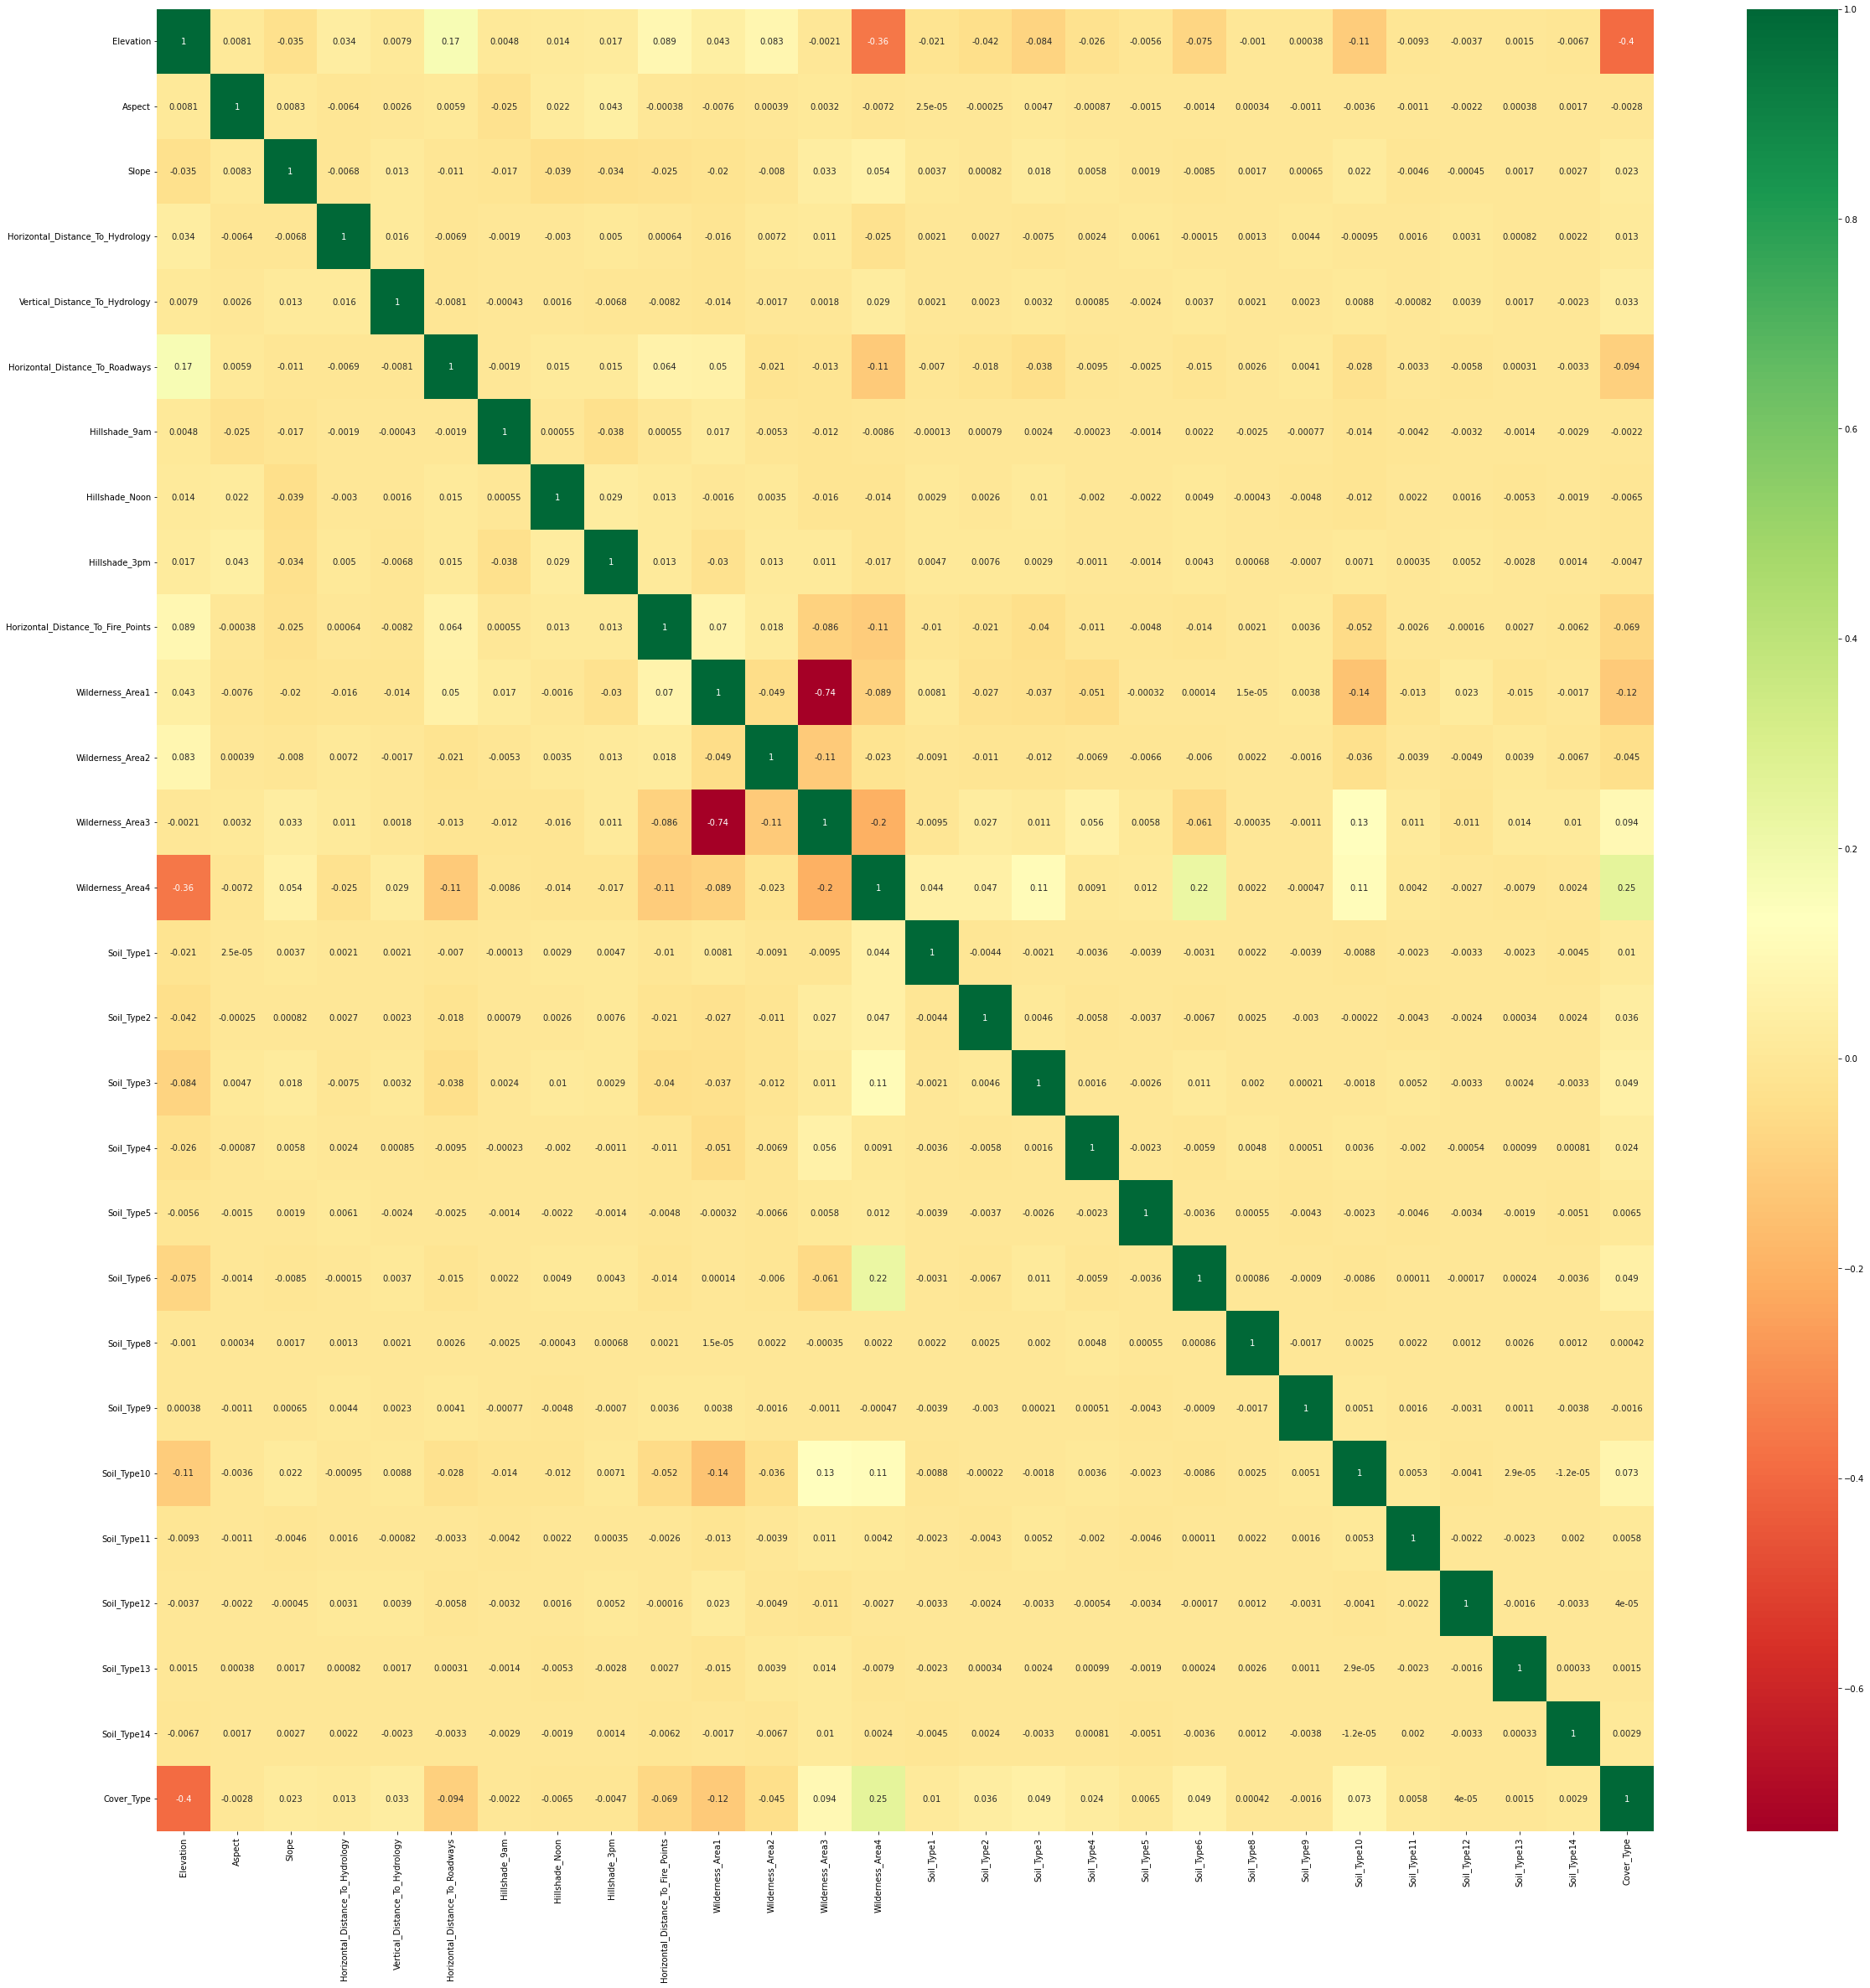

In [135]:
plt.figure(figsize=(40,40))
g=sns.heatmap(df_temp_a[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [88]:
featureScores.head()

,Specs,Score,Abs_score
0,Soil_Type8,27.180352,27.180352
1,Aspect,31.038621,31.038621
2,Soil_Type5,42.188371,42.188371
3,Hillshade_9am,60.698483,60.698483
4,Soil_Type25,68.949985,68.949985


In [ ]:
preds = model.predict(df_test)

output = pd.DataFrame({'Id': ids, 'Cover_Type': preds})
output.to_csv('submission.csv', index=False)

In [68]:
# get data
df_train, df_test, ids = get_datasets('../input/tabular-playground-series-dec-2021/')

# split data
X_train, X_val, y_train, y_val, original_features = split_dataset(df_train, df_test, target)

# get baseline score
model = LGBMClassifier(random_state=5)
val_score, cv_score = get_baseline_score(model, X_train, X_val, y_train, y_val)

# get models
models = get_models()

# get drop scores
model = LGBMClassifier(random_state=5)
df_drops = get_drop_scores(model, X_train, X_val, y_train, y_val, False)

# get feature importances
featureScores = get_feature_importances(X_train, y_train, 5)

# # get baseline scores
models = [
        {'name': 'lr', 'model': LogisticRegression(random_state=5)},
        # {'name': 'lsvc', 'model': LinearSVC(dual=False, random_state=5)},
        {'name': 'lgbm', 'model': LGBMClassifier(random_state=5)},
        # {'name': 'bayes', 'model': GaussianNB()},
    ]
# get_baseline_scores(models, X, y)

# # get baseline scores on validation set
# get_baseline_scores_validation(models, X_train, y_train, X_val, y_val)


# # get kmeans scores
# get_kmeans_scores(featureScores, X_train, X_val, df_test, models)

# # get kmeans scores on validation set
# get_kmeans_scores_validation(featureScores, X_train, X_val, df_test, models)

# # get stacking scores
# stack_model = LogisticRegression(solver='sag', C=1.6213309780417264, max_iter=1800, random_state=10)
# get_stacking_scores(featureScores, X_train, y_train, X_val, df_test, models, stack_model)

# # get stacking scores - pop 0
# models_stack = copy.deepcopy(models)
# models_stack.pop(0)
# stack_model = LogisticRegression(solver='sag', C=1.6213309780417264, max_iter=1800, random_state=10)
# get_stacking_scores(featureScores, X_train, y_train, X_val, df_test, models_stack, stack_model)

# # get binning scores
# baseline_score = 0.749
# model = LinearSVC(dual=False, C=0.012249147757314706, max_iter=10000)
# improved_cols = get_binning_scores(baseline_score, X_train, y_train, model, 0.01)

# # get binning scores on validation set
# baseline_score = 0.749
# model = LinearSVC(dual=False, C=0.012249147757314706, max_iter=10000)
# improved_cols = get_binning_scores_val(baseline_score, X_train, y_train, X_val, y_val, model, improvement)

# # optimize model
# optimize_linear_svc(X_train, y_train, X_val, y_val)

# # final prediction - single model - logistic regression
# clf = LogisticRegression(solver='newton-cg', C=0.023672809391721117, max_iter=200)
# make_final_pred_single(clf, X, y)